In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix, accuracy_score
from pathlib import Path
from tensorflow.keras.models import load_model


# Load data

In [2]:
current_dir = Path.cwd()
X_test_raw = np.load(current_dir / 'data' /'X_test_synthetic_raw.npy')


y_test = np.load(current_dir / 'data' /'y_test_synthetic.npy')
print(f" Shape of X_test: {X_test_raw.shape}, labels: {sum(y_test)}")
results = {}

with open(current_dir / 'data' / 'metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
    

 Shape of X_test: (214, 240, 6), labels: 28


# Function for metric evaluation

In [ ]:
def evaluate_anomaly_detector(model_name, y_true, anomaly_scores, results_dict):
    
    fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, thresholds = precision_recall_curve(y_true, anomaly_scores)
    pr_auc = average_precision_score(y_true, anomaly_scores)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0
    
    
    # 4. Save for comparison
    results_dict[model_name] = {
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
        'precision': precision, 'recall': recall, 'pr_auc': pr_auc,
        'scores': anomaly_scores,
        'best_threshold': best_threshold
    }
    

    return best_threshold

# Autoencoder (LSTM/CNN) 

In [4]:
ae_model_path = current_dir / 'models' / 'autoencoder' / 'autoencoder_anomaly_detector_20260213_185946.h5'
    
ae_model = tf.keras.models.load_model(ae_model_path, compile=False)
    
ae_scaler_path = current_dir / 'models' / 'autoencoder' / 'autoencoder_anomaly_detector_20260213_185946_scaler_map.pkl'
scaler_map = joblib.load(ae_scaler_path)

print("Autoencoder and scaler_map are loaded successfully.")

Autoencoder and scaler_map are loaded successfully.


In [5]:
N, L, F = X_test_raw.shape
X_test_ae = np.zeros_like(X_test_raw)

for i, metric_name in enumerate(METRIC_NAMES):
    if metric_name not in scaler_map:
        raise ValueError(f"Metric '{metric_name}' is missing from scaler_map!")
        
    scaler = scaler_map[metric_name]
    # get data for this feature, shape (N, L)
    feature_data = X_test_raw[:, :, i]
    
    # flatten to (N*L, 1) for StandardScaler 2D array [samples, features]
    feature_flat = feature_data.reshape(-1, 1)
    
    feature_scaled_flat = scaler.transform(feature_flat)
    
    # reshape back to (N, L) and assign to the corresponding slice
    X_test_ae[:, :, i] = feature_scaled_flat.reshape(N, L)

print("Data successfully normalized column-wise.")


Data successfully normalized column-wise.


c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.

In [6]:

reconstructions = ae_model.predict(X_test_ae, verbose=0)
# calculate MAE as an anomaly score
ae_scores = np.mean(np.abs(reconstructions - X_test_ae), axis=(1, 2))
    
evaluate_anomaly_detector('Autoencoder', y_test, ae_scores, results)

np.float64(1.8844743108429067)

# Isolation Forest

In [7]:
iforest_model_path = current_dir / 'models' / 'isolation_forest' / 'iforest_anomaly_detector_20260213_201837.pkl'
iforest_model = joblib.load(iforest_model_path)
    
iforest_scaler_path = current_dir / 'models' / 'isolation_forest' / 'iforest_anomaly_scaler_map_20260213_201837.pkl'
iforest_scaler = joblib.load(iforest_scaler_path)


print("Isolation forest and scaler_map are loaded successfully.")

Isolation forest and scaler_map are loaded successfully.


In [8]:
X_test_if = np.zeros_like(X_test_raw)

for i, metric_name in enumerate(METRIC_NAMES):
    scaler = iforest_scaler[metric_name] 
    feature_data = X_test_raw[:, :, i]
    feature_scaled_flat = scaler.transform(feature_data.reshape(-1, 1))
    X_test_if[:, :, i] = feature_scaled_flat.reshape(N, L)

X_test_if = X_test_if.reshape(N, -1)


c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.

In [9]:
if_scores_raw = iforest_model.decision_function(X_test_if)
if_scores = -if_scores_raw 
    
evaluate_anomaly_detector('Isolation Forest', y_test, if_scores, results)

np.float64(0.10426835489114405)

# OneClass SVM

In [10]:
svm_model_path = current_dir / 'models' / 'ocsvm' / 'ocsvm_anomaly_detector_20260213_194751.pkl'
svm_model = joblib.load(svm_model_path)

svm_scaler_path = current_dir / 'models' / 'ocsvm' / 'ocsvm_anomaly_scaler_map_20260213_194751.pkl'
svm_scaler = joblib.load(svm_scaler_path) 
    
print("OC-SVM is loaded.")


OC-SVM is loaded.


In [11]:
N, L, F = X_test_raw.shape
X_scaled_3d = np.zeros_like(X_test_raw)

for i, metric_name in enumerate(METRIC_NAMES):
    scaler = svm_scaler[metric_name] 
    feature_data = X_test_raw[:, :, i]
    feature_scaled_flat = scaler.transform(feature_data.reshape(-1, 1))
    X_scaled_3d[:, :, i] = feature_scaled_flat.reshape(N, L)

X_test_svm = X_scaled_3d.reshape(N, -1)

c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\system_performance_dataset\lib\site-packages\sklearn\utils\validation.

In [12]:
X_test_svm = X_scaled_3d.reshape(N, -1)
svm_scores = -svm_model.decision_function(X_test_svm)
evaluate_anomaly_detector('OneClass SVM', y_test, svm_scores, results)

np.float64(2.0849223274555038)

# Performance comparison

In [13]:

def get_performance_table(results_dict):
    
    summary_data = []
    
    for model_name, metrics in results_dict.items():
        # Дістаємо збережені масиви
        p = metrics['precision']
        r = metrics['recall']
        
        f1_scores = 2 * (p * r) / (p + r + 1e-9)
        best_idx = np.argmax(f1_scores)
        
        best_f1 = f1_scores[best_idx]
        best_precision = p[best_idx]
        best_recall = r[best_idx]
        
        summary_data.append({
            'Model': model_name,
            'F1 Score': best_f1,
            'Precision': best_precision,
            'Recall': best_recall,
            'PR AUC': metrics.get('pr_auc', 0),
            'ROC AUC': metrics.get('roc_auc', 0),
            'Best Threshold': metrics.get('best_threshold', 0)
        })
        
    df = pd.DataFrame(summary_data)
    df = df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    
    return df


df_metrics = get_performance_table(results)

print(df_metrics.to_string(float_format=lambda x: f"{x:.4f}"))

              Model  F1 Score  Precision  Recall  PR AUC  ROC AUC  Best Threshold
0      OneClass SVM    0.7234     0.8947  0.6071  0.7404   0.8765          2.0849
1       Autoencoder    0.5769     0.6250  0.5357  0.6254   0.8433          1.8845
2  Isolation Forest    0.3019     0.1832  0.8571  0.2190   0.6125          0.1043


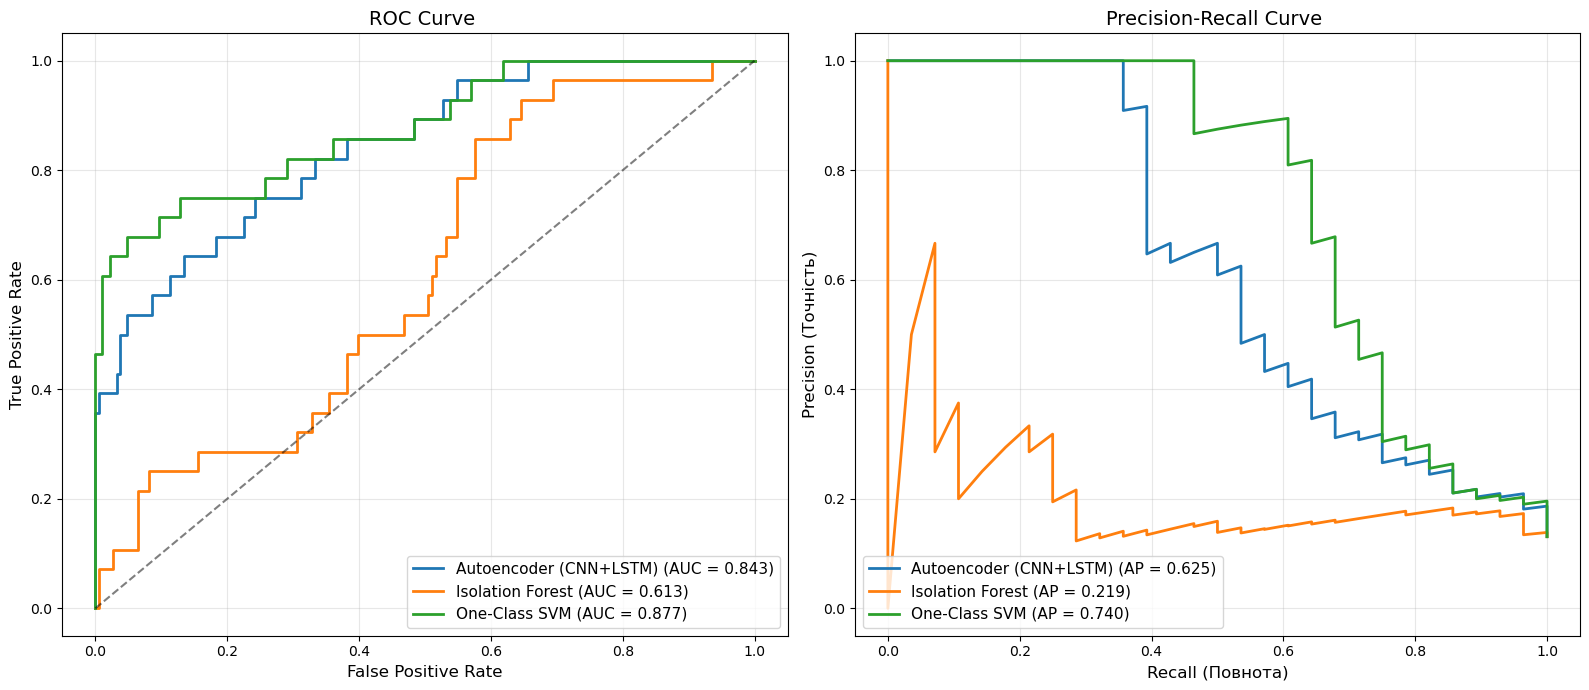

In [14]:

def plot_comparison_curves(y_true, scores_dict):

    plt.figure(figsize=(16, 7))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.subplot(1, 2, 1)
    for (name, score), color in zip(scores_dict.items(), colors):
        fpr, tpr, _ = roc_curve(y_true, score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', color=color, linewidth=2)
        
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) 
    plt.title('ROC Curve ', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for (name, score), color in zip(scores_dict.items(), colors):
        precision, recall, _ = precision_recall_curve(y_true, score)
        pr_auc = average_precision_score(y_true, score)
        plt.plot(recall, precision, label=f'{name} (AP = {pr_auc:.3f})', color=color, linewidth=2)
        
    plt.title('Precision-Recall Curve ', fontsize=14)
    plt.xlabel('Recall (Повнота)', fontsize=12)
    plt.ylabel('Precision (Точність)', fontsize=12)
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_comparison_curves(y_test, {
    'Autoencoder (CNN+LSTM)': ae_scores,       
    'Isolation Forest': if_scores,             
    'One-Class SVM': svm_scores           
})